# Brain Tumor Segmentation

This tutorial provides a step-by-step guide on how to use [medicai](https://github.com/innat/medic-ai), a [keras](https://keras.io/)-based medical image processing library that supports multiple backends. We will apply it to solve a multimodal Brain Tumor Segmentation task using the ([BraTS](https://www.med.upenn.edu/cbica/brats2020/data.html)) dataset. Throughout the tutorial, we will cover:

1. **Loading the Dataset**
    - Read TFRecord files that contain `image`, `label`, and `affine` matrix information.
    - Build efficient data pipelines using the `tf.data` API for training and evaluation.
2. **Medical Image Preprocessing**
    - Apply image transformations provided by `medicai` to prepare the data for model input.
3. **Model Building**
    - Use the [`SwinUNETR`](https://arxiv.org/abs/2201.01266) architecture from `medicai` for 3D medical image segmentation.
4. **Loss and Metrics Definition**
    - Implement a specialized Dice loss function and segmentation metrics available in `medicai` for better performance on medical data.
5. **Model Evaluation**
    - Use sliding window inference from `medicai` to efficiently perform inference on large 3D medical volumes.
    - Evaluate the model by calculating per-class metric scores after training is complete.
6. **Visualization of Results**
    - Visualize the model's predictions to qualitatively assess segmentation performance.

By the end of the tutorial, you will have a full workflow for brain tumor segmentation using `medicai`, from data loading to model evaluation and visualization.

In [1]:
from IPython.display import clear_output

!pip install tensorflow -qU
!pip install keras-nightly -qU
!pip install medicai -qU

clear_output()

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import keras
from keras import ops
from keras import layers
from keras import mixed_precision

import tensorflow as tf
from medicai.transforms import (
    Compose,
    CropForeground,
    Resize,
    Spacing,
    Orientation,
    RandShiftIntensity,
    RandRotate90,
    RandFlip,
    RandSpatialCrop,
    NormalizeIntensity,
    RandCropByPosNegLabel,
    TensorBundle
)
from medicai.models import SwinUNETR
from medicai.metrics import BinaryDiceMetric
from medicai.losses import BinaryDiceCELoss
from medicai.utils.inference import SlidingWindowInference
from medicai.callbacks import SlidingWindowInferenceCallback

print(
    'keras backend: ', keras.backend.backend(), '\n'
    'keras version: ', keras.version(), '\n'
    'tensorflow version: ', tf.__version__, '\n'
)

2025-04-27 06:30:25.088810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745735425.110178      19 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745735425.116868      19 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745735425.135039      19 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745735425.135058      19 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745735425.135060      19 computation_placer.cc:177] computation placer alr

keras backend:  tensorflow 
keras version:  3.10.0.dev2025042703 
tensorflow version:  2.19.0 



In [3]:
# enable mixed precision
keras.mixed_precision.set_global_policy("mixed_bfloat16")

# reproducibility
keras.utils.set_random_seed(101)

strategy = tf.distribute.MirroredStrategy()
total_device = strategy.num_replicas_in_sync
total_device

I0000 00:00:1745735433.288452      19 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745735433.292307      19 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


2

# Dataset

**Understanding the BraTS Dataset and Preparing TFRecord Files**: The `.nii` format BraTS scans can be found [here](https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation/). We have converted the raw format to `tfrecord` format. The format process can be found [here](https://www.kaggle.com/code/ipythonx/brats-nii-to-tfrecord). The converted `tfrecord` dataset can be found [here](https://www.kaggle.com/datasets/ipythonx/brats2020). Each `tfrecord` file contains max 10 file in each. As there is no publickly available validation or testing ground truth dataset, we can keep any `tfrecord` file(s) aside from training for validation.

[**Imaging Data Description**](https://www.med.upenn.edu/cbica/brats2020/data.html): All BraTS multimodal scans are available as NIfTI files (.nii.gz) and describe a) native (**T1**) and b) post-contrast T1-weighted (**T1Gd**), c) T2-weighted (**T2**), and d) T2 Fluid Attenuated Inversion Recovery (**T2-FLAIR**) volumes, and were acquired with different clinical protocols and various scanners from multiple (n=19) institutions, mentioned as data contributors here.

All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (**ET — label 4**), the peritumoral edema (**ED — label 2**), and the necrotic and non-enhancing tumor core (**NCR/NET — label 1**), as described both in the [BraTS 2012-2013 TMI paper](https://ieeexplore.ieee.org/document/6975210) and in the [latest BraTS summarizing paper](https://arxiv.org/abs/1811.02629). The provided data are distributed after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm^3) and skull-stripped. In short, the segmentation labels have values of 1 for **NCR**, 2 for **ED**, 4 for **ET**, and 0 for everything else.

# Create Multi-label Brain Tumor Labels

The segmentation task involves multiple tumor sub-regions, and it is formulated as a multi-label segmentation problem. The label combinations are used to define the following clinical regions of interest:

- Tumor Core (**TC**): label = 1 or 4
- Whole Tumor (**WT**): label = 1 or 2 or 4
- Enhancing Tumor (**ET**): label = 4

These region-wise groupings allow for evaluation across different tumor structures relevant for clinical assessment and treatment planning. A sample view is shown below, figure taken from [BraTS-benchmark](https://arxiv.org/pdf/2107.02314v1) paper.


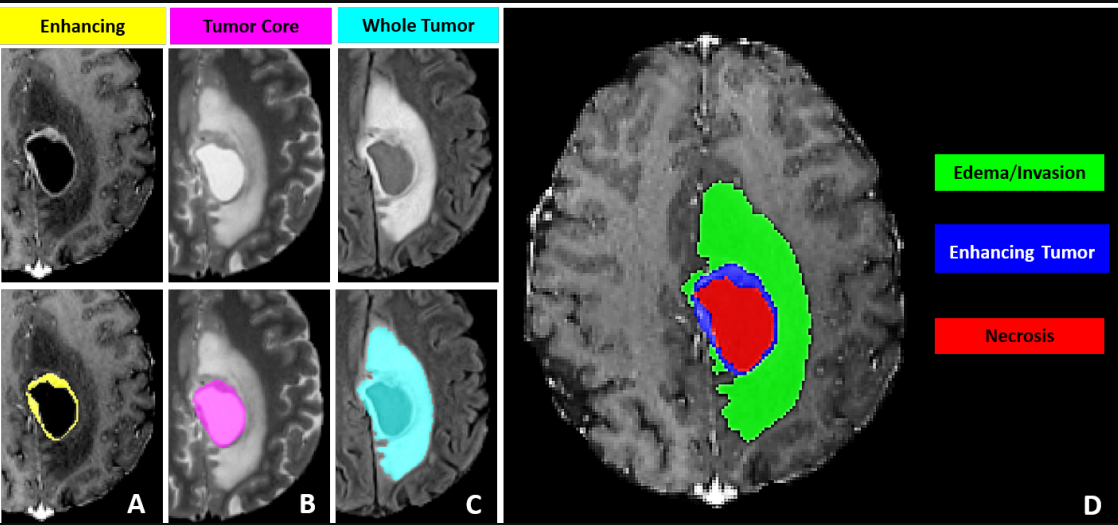

In [4]:
class ConvertToMultiChannelBasedOnBratsClasses:
    """
    Convert labels to multi channels based on BRATS classes using TensorFlow.

    Label definitions:
    - 1: necrotic and non-enhancing tumor core
    - 2: peritumoral edema
    - 4: GD-enhancing tumor

    Output channels:
    - Channel 0 (TC): Tumor core (labels 1 or 4)
    - Channel 1 (WT): Whole tumor (labels 1, 2, or 4)
    - Channel 2 (ET): Enhancing tumor (label 4)
    """

    def __init__(self, keys):
        self.keys = keys

    def __call__(self, inputs):
        if isinstance(inputs, dict):
            inputs = TensorBundle(inputs)

        for key in self.keys:
            data = inputs.data[key]

            # TC: label == 1 or 4
            tc = tf.logical_or(tf.equal(data, 1), tf.equal(data, 4))

            # WT: label == 1 or 2 or 4
            wt = tf.logical_or(
                tf.logical_or(tf.equal(data, 1), tf.equal(data, 4)),
                tf.equal(data, 2)
            )

            # ET: label == 4
            et = tf.equal(data, 4)

            stacked = tf.stack([
                tf.cast(tc, tf.float32),
                tf.cast(wt, tf.float32),
                tf.cast(et, tf.float32)
            ], axis=-1)

            inputs.data[key] = stacked
        return inputs

# Transformation

Each `medicai` transformation expects the input to have the shape `(depth, height, width, channel)`. The original `.nii` (and converted `.tfrecord`) format contains the input shape of `(height, width, depth)`. To make it compatible with `medicai`, we need to re-arrange the shape axes.

In [5]:
def rearrange_shape(sample):
    image = sample['image']
    label = sample['label']
    affine = sample['affine']

    # special case
    image = tf.transpose(image, perm=[2, 1, 0, 3])  # whdc -> dhwc
    label = tf.transpose(label, perm=[2, 1, 0])  # whd -> dhw
    cols = tf.gather(affine, [2, 1, 0], axis=1)  # (whd) -> (dhw)
    affine = tf.concat([cols, affine[:, 3:]], axis=1)

    # re-update sample with new / updated tensor
    sample['image'] = image
    sample['label'] = label
    sample['affine'] = affine
    return sample

## TensorBundle

The **TensorBundle** is a simple container class API from `medicai` for holding a dictionary of tensors and associated metadata. This class is designed to bundle together the actual **data** (tensors) and any relevant **metadata** (e.g., affine transformations, original shapes, spacing) related to that data. It provides convenient access and modification methods for both the data and the metadata.

Each transformation class of `medicai` expects input as either a dictionary or a `TensorBundle` object. When a dictionary of input data (along with metadata) is passed, it is automatically wrapped into a `TensorBundle` instance. The examples below demonstrate how transformations are used in this way.


In [6]:
def train_transformation(sample):
    meta = {"affine": sample["affine"]}
    data = {"image": sample["image"], "label": sample["label"]}
    pipeline = Compose([
        ConvertToMultiChannelBasedOnBratsClasses(keys=["label"]),
        CropForeground(
            keys=("image", "label"),
            source_key="image",
            k_divisible=[96, 96, 96],
        ),
        RandSpatialCrop(
            keys=["image", "label"],
            roi_size=(96, 96, 96),
            random_size=False
        ),
        RandFlip(keys=["image", "label"], spatial_axis=[0], prob=0.5),
        RandFlip(keys=["image", "label"], spatial_axis=[1], prob=0.5),
        RandFlip(keys=["image", "label"], spatial_axis=[2], prob=0.5),
        NormalizeIntensity(
            keys=["image"],
            nonzero=True,
            channel_wise=True
        ),
        RandShiftIntensity(
            keys=["image"],
            offsets=0.10,
            prob=1.0
        )
    ])
    result = pipeline(data, meta)
    return result["image"], result["label"]


def val_transformation(sample):
    meta = {"affine": sample["affine"]}
    data = {"image": sample["image"], "label": sample["label"]}
    pipeline = Compose([
        ConvertToMultiChannelBasedOnBratsClasses(keys=["label"]),
        NormalizeIntensity(
            keys=["image"],
            nonzero=True,
            channel_wise=True
        )
    ])
    result = pipeline(data, meta)
    return result["image"], result["label"]

In [7]:
def parse_tfrecord_fn(example_proto):
    feature_description = {
        # Image raw data
        "flair_raw": tf.io.FixedLenFeature([], tf.string),
        "t1_raw": tf.io.FixedLenFeature([], tf.string),
        "t1ce_raw": tf.io.FixedLenFeature([], tf.string),
        "t2_raw": tf.io.FixedLenFeature([], tf.string),
        "label_raw": tf.io.FixedLenFeature([], tf.string),

        # Image shape
        "flair_shape": tf.io.FixedLenFeature([3], tf.int64),
        "t1_shape": tf.io.FixedLenFeature([3], tf.int64),
        "t1ce_shape": tf.io.FixedLenFeature([3], tf.int64),
        "t2_shape": tf.io.FixedLenFeature([3], tf.int64),
        "label_shape": tf.io.FixedLenFeature([3], tf.int64),

        # Affine matrices (4x4 = 16 values)
        "flair_affine": tf.io.FixedLenFeature([16], tf.float32),
        "t1_affine": tf.io.FixedLenFeature([16], tf.float32),
        "t1ce_affine": tf.io.FixedLenFeature([16], tf.float32),
        "t2_affine": tf.io.FixedLenFeature([16], tf.float32),
        "label_affine": tf.io.FixedLenFeature([16], tf.float32),

        # Voxel Spacing (pixdim)
        "flair_pixdim": tf.io.FixedLenFeature([8], tf.float32),
        "t1_pixdim": tf.io.FixedLenFeature([8], tf.float32),
        "t1ce_pixdim": tf.io.FixedLenFeature([8], tf.float32),
        "t2_pixdim": tf.io.FixedLenFeature([8], tf.float32),
        "label_pixdim": tf.io.FixedLenFeature([8], tf.float32),

        # Filenames
        "flair_filename": tf.io.FixedLenFeature([], tf.string),
        "t1_filename": tf.io.FixedLenFeature([], tf.string),
        "t1ce_filename": tf.io.FixedLenFeature([], tf.string),
        "t2_filename": tf.io.FixedLenFeature([], tf.string),
        "label_filename": tf.io.FixedLenFeature([], tf.string),
    }

    example = tf.io.parse_single_example(
        example_proto, feature_description
    )

    # Decode image and label data
    flair = tf.io.decode_raw(example["flair_raw"], tf.float32)
    t1 = tf.io.decode_raw(example["t1_raw"], tf.float32)
    t1ce = tf.io.decode_raw(example["t1ce_raw"], tf.float32)
    t2 = tf.io.decode_raw(example["t2_raw"], tf.float32)
    label = tf.io.decode_raw(example["label_raw"], tf.float32)

    # Reshape to original dimensions
    flair = tf.reshape(flair, example["flair_shape"])
    t1 = tf.reshape(t1, example["t1_shape"])
    t1ce = tf.reshape(t1ce, example["t1ce_shape"])
    t2 = tf.reshape(t2, example["t2_shape"])
    label = tf.reshape(label, example["label_shape"])

    # Decode affine matrices
    flair_affine = tf.reshape(example["flair_affine"], (4, 4))
    t1_affine = tf.reshape(example["t1_affine"], (4, 4))
    t1ce_affine = tf.reshape(example["t1ce_affine"], (4, 4))
    t2_affine = tf.reshape(example["t2_affine"], (4, 4))
    label_affine = tf.reshape(example["label_affine"], (4, 4))


    # add channel axis
    flair = flair[..., None]
    t1 = t1[..., None]
    t1ce = t1ce[..., None]
    t2 = t2[..., None]
    image = tf.concat([flair, t1, t1ce, t2], axis=-1)

    return {
        "image": image,
        "label": label,
        "affine": flair_affine, # Since affine is the same for all
    }

# Dataloader

In [8]:
def load_tfrecord_dataset(tfrecord_datalist, batch_size=1, shuffle=True):
    dataset = tf.data.TFRecordDataset(tfrecord_datalist)
    dataset = dataset.shuffle(buffer_size=100) if shuffle else dataset
    dataset = dataset.map(
        parse_tfrecord_fn,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.map(
        rearrange_shape,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    if shuffle:
        dataset = dataset.map(
            train_transformation,
            num_parallel_calls=tf.data.AUTOTUNE
        )
    else:
        dataset = dataset.map(
            val_transformation,
            num_parallel_calls=tf.data.AUTOTUNE
        )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [9]:
tfrecord_pattern = "/kaggle/input/brats2020/training_shard_*.tfrec"
datalist = sorted(
    tf.io.gfile.glob(tfrecord_pattern),
    key=lambda x: int(x.split("_")[-1].split(".")[0])
)

train_datalist = datalist[:-1]
val_datalist = datalist[-1:]
print(len(train_datalist), len(val_datalist))
print(val_datalist)

36 1
['/kaggle/input/brats2020/training_shard_36.tfrec']


In [10]:
# batch size for training
train_batch = 1 * strategy.num_replicas_in_sync

train_ds = load_tfrecord_dataset(
    train_datalist, batch_size=train_batch, shuffle=True
)
val_ds = load_tfrecord_dataset(
    val_datalist, batch_size=1, shuffle=False
)

In [11]:
val_x, val_y = next(iter(val_ds))
test_image = val_x.numpy().squeeze()
test_mask = val_y.numpy().squeeze()
print(test_image.shape, test_mask.shape, np.unique(test_mask))
print(test_image.min(), test_image.max())

(155, 240, 240, 4) (155, 240, 240, 3) [0. 1.]
-3.8107734 12.865826


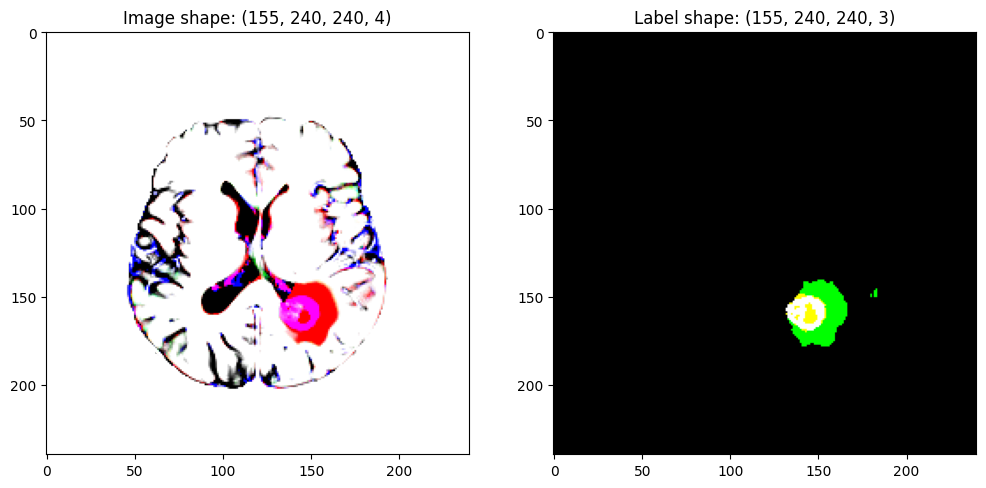

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(test_image[test_image.shape[0]//2], cmap='gray')
ax1.set_title(f'Image shape: {test_image.shape}')
ax2.imshow(test_mask[test_mask.shape[0]//2])
ax2.set_title(f'Label shape: {test_mask.shape}')
plt.show()

image shape: (155, 240, 240, 4)


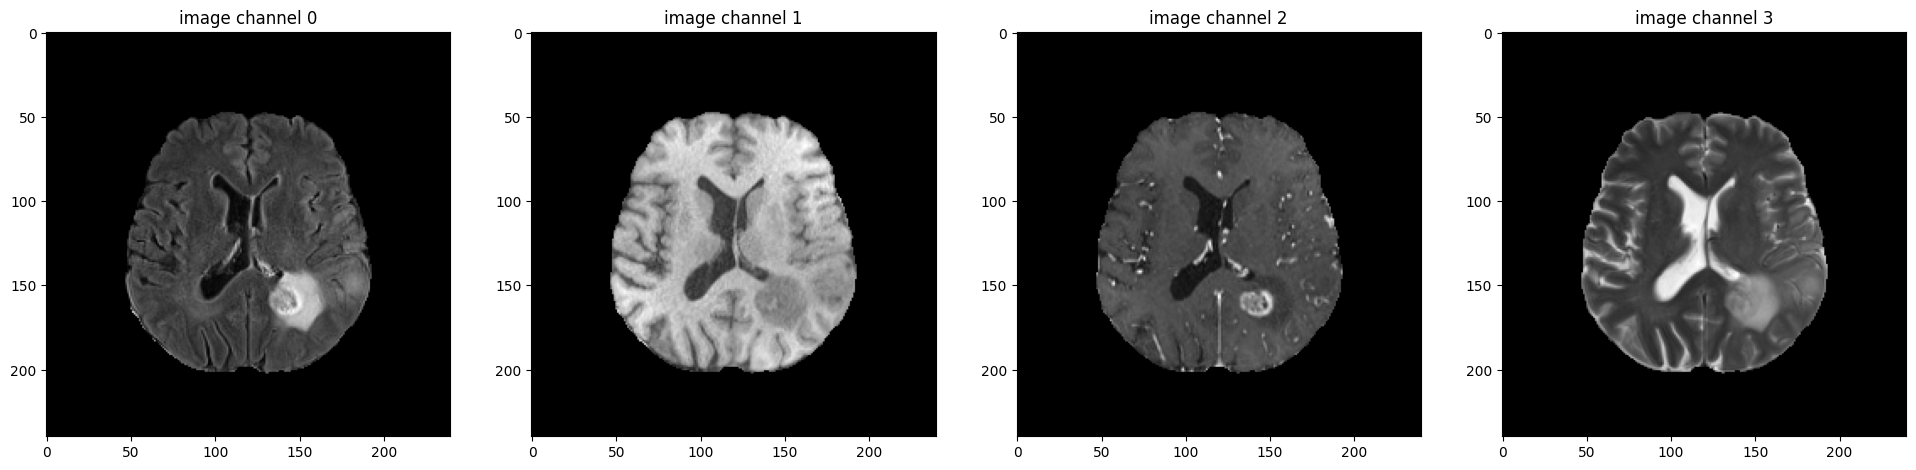

label shape: (155, 240, 240, 3)


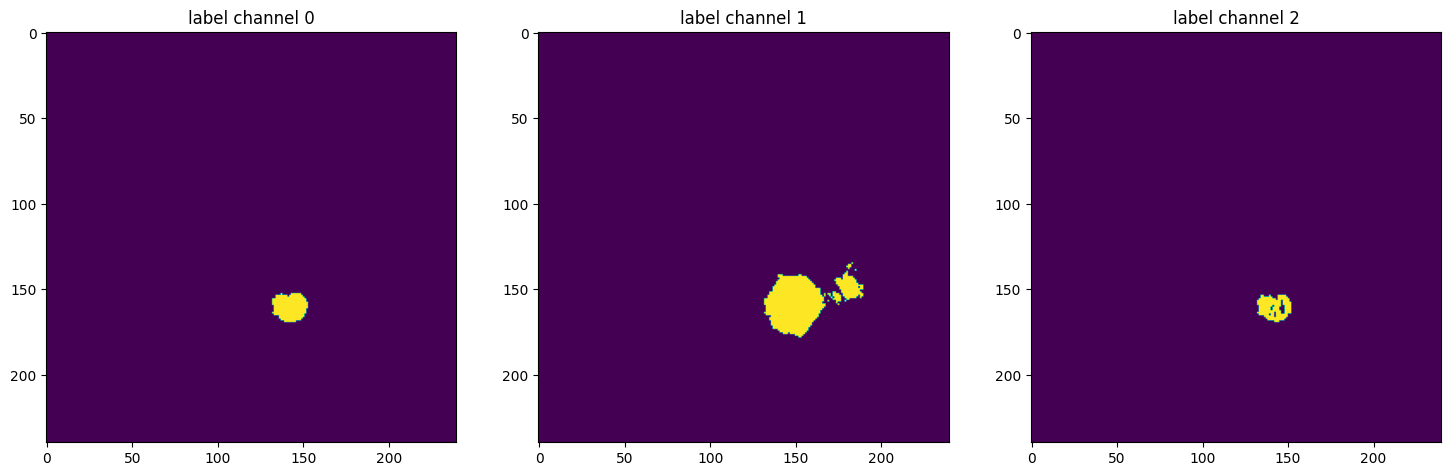

In [13]:
print(f"image shape: {test_image.shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(test_image[80, :, :, i], cmap="gray")
plt.show()


print(f"label shape: {test_mask.shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(test_mask[80, :, :, i])
plt.show()

# Model

We will be using the 3D model architecture [`SwinUNETR`](https://arxiv.org/abs/2201.01266). The BraTS dataset provides four input modalities: `flair`, `t1`, `t1ce`, and `t2`. Accordingly, we will build the model with **4** input channels and **3** output channels.

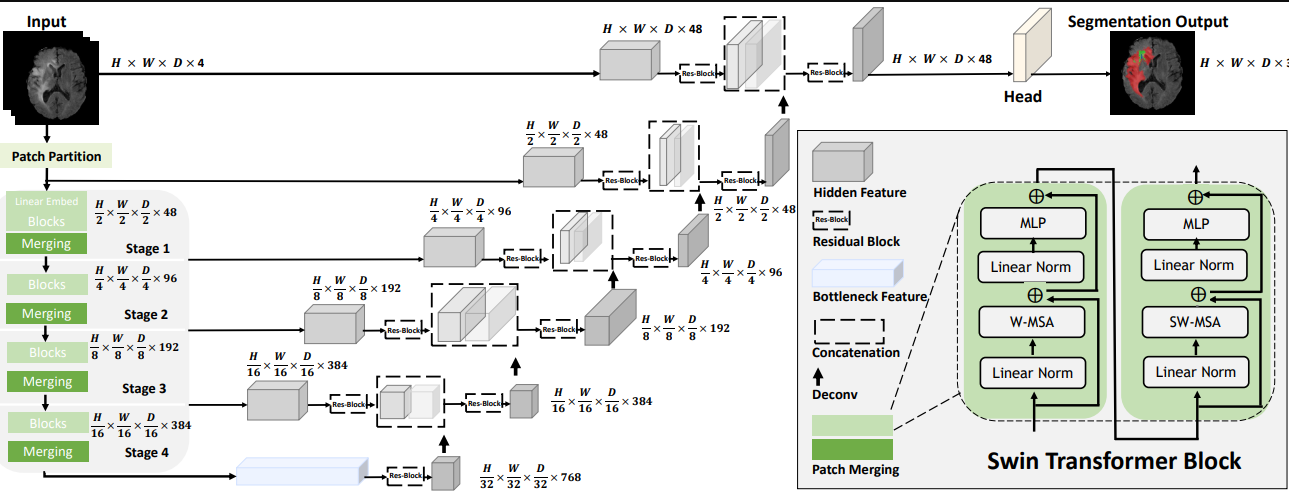

In [14]:
num_classes=3
epochs = 25
input_shape=(96, 96, 96, 4)

with strategy.scope():
    model = SwinUNETR(
        input_shape=input_shape,
        num_classes=num_classes,
        classifier_activation=None,
    )

    model.compile(
        optimizer=keras.optimizers.AdamW(
            learning_rate=1e-4,
            weight_decay=1e-5,
        ),
        loss=BinaryDiceCELoss(
            from_logits=True,
            num_classes=num_classes,
        ),
        metrics=[
            BinaryDiceMetric(
                from_logits=True,
                ignore_empty=True,
                num_classes=num_classes,
                name='dice',
            ),
            BinaryDiceMetric(
                from_logits=True,
                ignore_empty=True,
                class_ids=[0],
                num_classes=num_classes,
                name='dice_tc',
            ),
            BinaryDiceMetric(
                from_logits=True,
                ignore_empty=True,
                class_ids=[1],
                num_classes=num_classes,
                name='dice_wt',
            ),
            BinaryDiceMetric(
                from_logits=True,
                ignore_empty=True,
                class_ids=[2],
                num_classes=num_classes,
                name='dice_et',
            )
        ],
    )

# Callback

We will be using sliding window inference callback to perform validation at certain interval or epoch during training. Based on the number of `epoch` size, set `interval` accordingly. For example, if `epoch` is set 15 and we want to evaluate model on validation set every 5 epoch, then set `interval` to 5.

In [15]:
with strategy.scope():
    swi_callback_metric = BinaryDiceMetric(
        from_logits=True,
        ignore_empty=True,
        num_classes=num_classes,
        name='val_dice',
    )

swi_callback = SlidingWindowInferenceCallback(
    model,
    dataset=val_ds,
    metrics=swi_callback_metric,
    num_classes=num_classes,
    interval=5,
    overlap=0.5,
    roi_size=(96, 96, 96),
    sw_batch_size=4 * total_device,
    save_path="brats.model.weights.h5"
)

# Training

Set more epoch for better optimization.

In [16]:
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[
        swi_callback
    ]
)

Epoch 1/25


I0000 00:00:1745735819.784109      82 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745735819.784124      79 cuda_dnn.cc:529] Loaded cuDNN version 90300


180/180 ━━━━━━━━━━━━━━━━━━━━ 804s 3s/step - dice: 0.3165 - dice_et: 0.2023 - dice_tc: 0.1495 - dice_wt: 0.5975 - loss: 2.6340
Epoch 2/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 581s 3s/step - dice: 0.7019 - dice_et: 0.6978 - dice_tc: 0.6261 - dice_wt: 0.7819 - loss: 1.9305
Epoch 3/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 574s 3s/step - dice: 0.7382 - dice_et: 0.6939 - dice_tc: 0.6680 - dice_wt: 0.8483 - loss: 1.7658
Epoch 4/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 578s 3s/step - dice: 0.7798 - dice_et: 0.7538 - dice_tc: 0.7347 - dice_wt: 0.8509 - loss: 1.6108
Epoch 5/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - dice: 0.7684 - dice_et: 0.7580 - dice_tc: 0.6969 - dice_wt: 0.8504 - loss: 1.5119
Epoch 5: Running inference...


Total patch 48: 100%|██████████| 6/6 [00:19<00:00,  3.30s/it]


Epoch 5: Score = 0.6720
New best score! Model saved to brats.model.weights.h5
180/180 ━━━━━━━━━━━━━━━━━━━━ 780s 4s/step - dice: 0.7686 - dice_et: 0.7582 - dice_tc: 0.6971 - dice_wt: 0.8505 - loss: 1.5118
Epoch 6/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 569s 3s/step - dice: 0.8086 - dice_et: 0.7936 - dice_tc: 0.7598 - dice_wt: 0.8668 - loss: 1.3959
Epoch 7/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 562s 3s/step - dice: 0.8038 - dice_et: 0.7920 - dice_tc: 0.7487 - dice_wt: 0.8659 - loss: 1.3398
Epoch 8/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 572s 3s/step - dice: 0.8145 - dice_et: 0.7987 - dice_tc: 0.7722 - dice_wt: 0.8726 - loss: 1.2737
Epoch 9/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 569s 3s/step - dice: 0.8321 - dice_et: 0.8328 - dice_tc: 0.7768 - dice_wt: 0.8867 - loss: 1.2047
Epoch 10/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - dice: 0.8161 - dice_et: 0.8113 - dice_tc: 0.7607 - dice_wt: 0.8705 - loss: 1.2019
Epoch 10: Running inference...


Total patch 48: 100%|██████████| 6/6 [00:19<00:00,  3.30s/it]


Epoch 10: Score = 0.7473
New best score! Model saved to brats.model.weights.h5
180/180 ━━━━━━━━━━━━━━━━━━━━ 737s 4s/step - dice: 0.8162 - dice_et: 0.8114 - dice_tc: 0.7607 - dice_wt: 0.8706 - loss: 1.2018
Epoch 11/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 563s 3s/step - dice: 0.8352 - dice_et: 0.8303 - dice_tc: 0.7834 - dice_wt: 0.8809 - loss: 1.0874
Epoch 12/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 558s 3s/step - dice: 0.8338 - dice_et: 0.8203 - dice_tc: 0.7979 - dice_wt: 0.8833 - loss: 1.0930
Epoch 13/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 573s 3s/step - dice: 0.8517 - dice_et: 0.8434 - dice_tc: 0.8183 - dice_wt: 0.8935 - loss: 1.0304
Epoch 14/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 569s 3s/step - dice: 0.8474 - dice_et: 0.8421 - dice_tc: 0.8015 - dice_wt: 0.8890 - loss: 1.0234
Epoch 15/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - dice: 0.8371 - dice_et: 0.8246 - dice_tc: 0.7956 - dice_wt: 0.8866 - loss: 1.0185
Epoch 15: Running inference...


Total patch 48: 100%|██████████| 6/6 [00:19<00:00,  3.29s/it]


Epoch 15: Score = 0.7524
New best score! Model saved to brats.model.weights.h5
180/180 ━━━━━━━━━━━━━━━━━━━━ 754s 4s/step - dice: 0.8371 - dice_et: 0.8247 - dice_tc: 0.7956 - dice_wt: 0.8866 - loss: 1.0187
Epoch 16/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 575s 3s/step - dice: 0.8525 - dice_et: 0.8370 - dice_tc: 0.8258 - dice_wt: 0.8945 - loss: 0.9336
Epoch 17/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 570s 3s/step - dice: 0.8456 - dice_et: 0.8403 - dice_tc: 0.8069 - dice_wt: 0.8895 - loss: 0.9381
Epoch 18/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 580s 3s/step - dice: 0.8525 - dice_et: 0.8403 - dice_tc: 0.8206 - dice_wt: 0.8941 - loss: 0.9884
Epoch 19/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 563s 3s/step - dice: 0.8467 - dice_et: 0.8354 - dice_tc: 0.8085 - dice_wt: 0.8961 - loss: 0.9451
Epoch 20/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - dice: 0.8521 - dice_et: 0.8496 - dice_tc: 0.8059 - dice_wt: 0.9009 - loss: 0.9144
Epoch 20: Running inference...


Total patch 48: 100%|██████████| 6/6 [00:19<00:00,  3.30s/it]


Epoch 20: Score = 0.7870
New best score! Model saved to brats.model.weights.h5
180/180 ━━━━━━━━━━━━━━━━━━━━ 737s 3s/step - dice: 0.8521 - dice_et: 0.8496 - dice_tc: 0.8059 - dice_wt: 0.9009 - loss: 0.9145
Epoch 21/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 571s 3s/step - dice: 0.8563 - dice_et: 0.8476 - dice_tc: 0.8275 - dice_wt: 0.8937 - loss: 0.9082
Epoch 22/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 563s 3s/step - dice: 0.8568 - dice_et: 0.8495 - dice_tc: 0.8186 - dice_wt: 0.8987 - loss: 0.9302
Epoch 23/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 568s 3s/step - dice: 0.8535 - dice_et: 0.8252 - dice_tc: 0.8301 - dice_wt: 0.8952 - loss: 0.9440
Epoch 24/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 578s 3s/step - dice: 0.8507 - dice_et: 0.8327 - dice_tc: 0.8211 - dice_wt: 0.8984 - loss: 0.9376
Epoch 25/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - dice: 0.8510 - dice_et: 0.8461 - dice_tc: 0.8064 - dice_wt: 0.9005 - loss: 0.8768
Epoch 25: Running inference...


Total patch 48: 100%|██████████| 6/6 [00:20<00:00,  3.35s/it]


Epoch 25: Score = 0.7795
180/180 ━━━━━━━━━━━━━━━━━━━━ 736s 3s/step - dice: 0.8511 - dice_et: 0.8462 - dice_tc: 0.8065 - dice_wt: 0.9005 - loss: 0.8770


In [17]:
print(model.history.history.keys())
his_csv = pd.DataFrame(model.history.history)
his_csv.to_csv('brats.history.csv')
his_csv.head()

dict_keys(['dice', 'dice_et', 'dice_tc', 'dice_wt', 'loss'])


,dice,dice_et,dice_tc,dice_wt,loss
0,0.415340,0.317096,0.229406,0.699517,2.295000
1,0.715887,0.700634,0.645468,0.801560,1.901156
2,0.747141,0.715506,0.679049,0.846867,1.747168
3,0.780837,0.772248,0.721539,0.848723,1.629545
4,0.790751,0.783569,0.727081,0.861602,1.486037


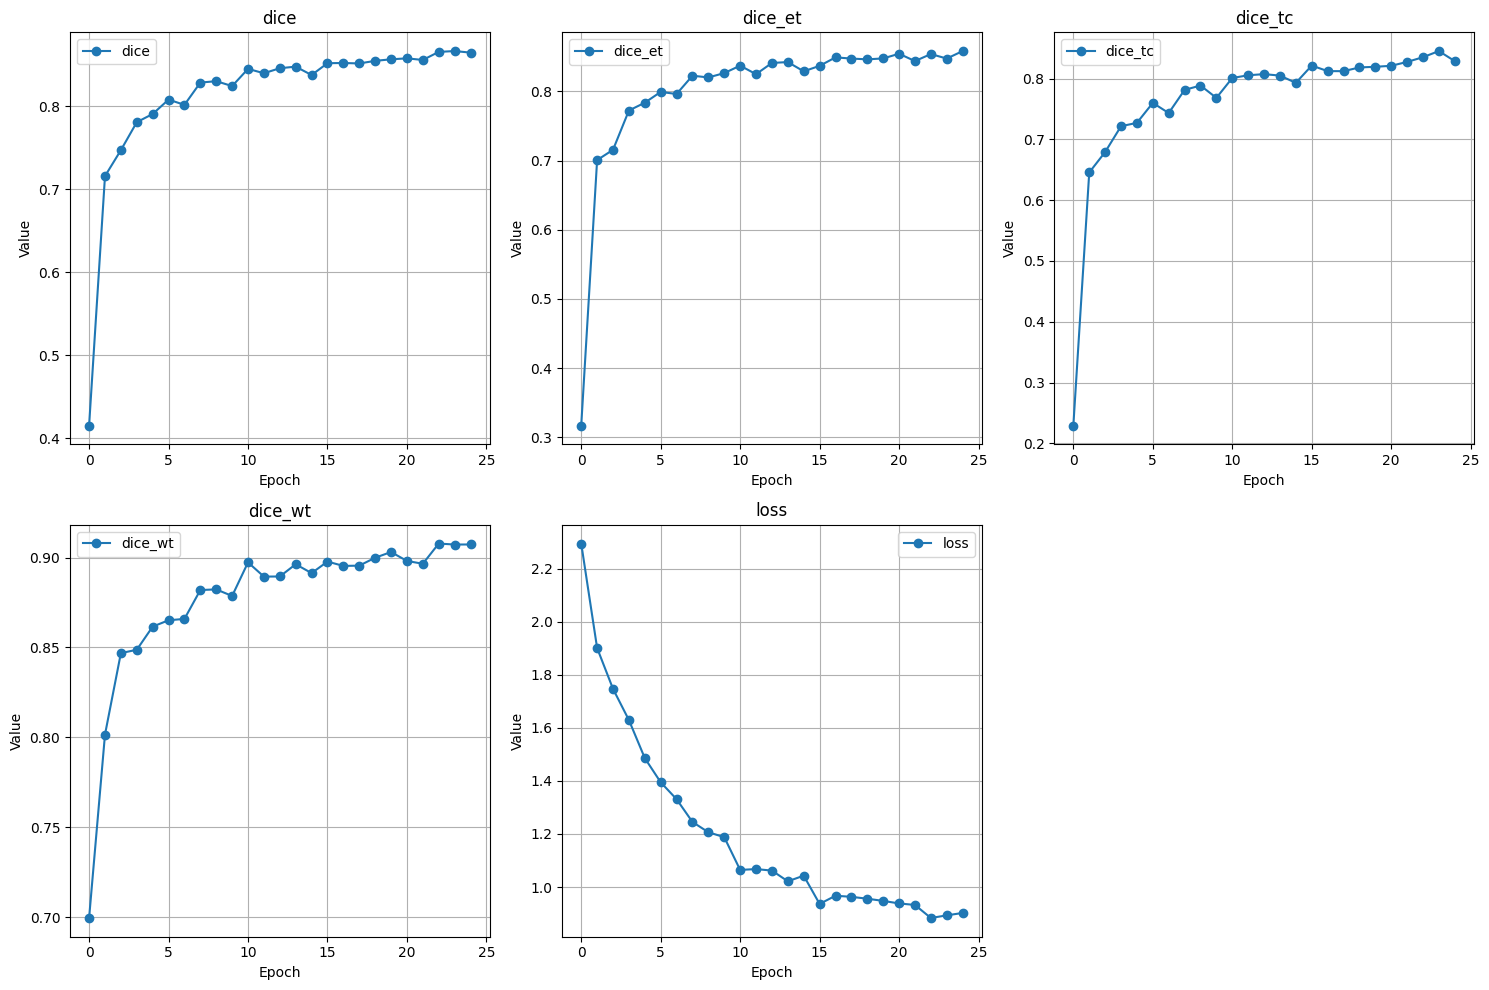

In [18]:
def plot_training_history(history_df):
    metrics = history_df.columns
    n_metrics = len(metrics)

    n_rows = 2
    n_cols = (n_metrics + 1) // 2  # ceiling division for columns

    plt.figure(figsize=(5 * n_cols, 5 * n_rows))

    for idx, metric in enumerate(metrics):
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.plot(history_df[metric], label=metric, marker='o')
        plt.title(metric)
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()


plot_training_history(his_csv)

# Evaluation

We can evaluate the model per-class or on average.

In [19]:
model.load_weights(
    "brats.model.weights.h5"
)
swi = SlidingWindowInference(
    model,
    num_classes=num_classes,
    roi_size=(96, 96, 96),
    sw_batch_size=4 * total_device,
    overlap=0.5,
)

In [20]:
dice = BinaryDiceMetric(
    from_logits=True,
    ignore_empty=True,
    num_classes=num_classes,
    name='dice',
)
dice_tc = BinaryDiceMetric(
    from_logits=True,
    ignore_empty=True,
    class_ids=[0],
    num_classes=num_classes,
    name='dice_tc',
)
dice_wt = BinaryDiceMetric(
    from_logits=True,
    ignore_empty=True,
    class_ids=[1],
    num_classes=num_classes,
    name='dice_wt',
)
dice_et = BinaryDiceMetric(
    from_logits=True,
    ignore_empty=True,
    class_ids=[2],
    num_classes=num_classes,
    name='dice_et',
)

In [21]:
for sample in val_ds:
    x, y = sample
    output = swi(x)

    y = ops.convert_to_tensor(y)
    output = ops.convert_to_tensor(output)

    dice.update_state(y, output)
    dice_tc.update_state(y, output)
    dice_wt.update_state(y, output)
    dice_et.update_state(y, output)

dice_score = float(ops.convert_to_numpy(dice.result()))
dice_score_tc = float(ops.convert_to_numpy(dice_tc.result()))
dice_score_wt = float(ops.convert_to_numpy(dice_wt.result()))
dice_score_et = float(ops.convert_to_numpy(dice_et.result()))

print(f"Dice Score: {dice_score:.4f}")
print(f"Dice Score on TC: {dice_score_tc:.4f}")
print(f"Dice Score on WT: {dice_score_wt:.4f}")
print(f"Dice Score on ET: {dice_score_et:.4f}")

dice.reset_state()
dice_tc.reset_state()
dice_wt.reset_state()
dice_et.reset_state()

Total patch 48: 100%|██████████| 6/6 [00:20<00:00,  3.34s/it]


Dice Score: 0.7870
Dice Score on TC: 0.6081
Dice Score on WT: 0.9211
Dice Score on ET: 0.8319


# Analyse and Visualize

In [22]:
def test_transformation(sample):
    data = {"image": sample["image"], "label": sample["label"]}
    pipeline = Compose([
        ConvertToMultiChannelBasedOnBratsClasses(keys=["label"]),
        NormalizeIntensity(
            keys=["image"],
            nonzero=True,
            channel_wise=True
        )
    ])
    result = pipeline(data)
    return result["image"], result["label"]

In [23]:
index = 0
dataset = tf.data.TFRecordDataset(val_datalist[index])
dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(rearrange_shape, num_parallel_calls=tf.data.AUTOTUNE)

In [24]:
sample = next(iter(dataset))
orig_image = sample['image']
orig_label = sample['label']
orig_affine = sample['affine']
print(
    orig_image.shape, orig_label.shape, orig_affine.shape, np.unique(orig_label)
)

(155, 240, 240, 4) (155, 240, 240) (4, 4) [0. 1. 2. 4.]


In [25]:
pre_image, pre_label = test_transformation(sample)
print(
    pre_image.shape, pre_label.shape
)

(155, 240, 240, 4) (155, 240, 240, 3)


In [26]:
y_pred = swi(pre_image[None, ...])
y_pred.shape

Total patch 48: 100%|██████████| 6/6 [00:19<00:00,  3.30s/it]


(1, 155, 240, 240, 3)

In [27]:
y_pred_logits = y_pred.squeeze(axis=0)
y_pred_prob = ops.convert_to_numpy(ops.sigmoid(y_pred_logits))
segment = (y_pred_prob > 0.5).astype(int)
segment.shape, np.unique(segment)

((155, 240, 240, 3), array([0, 1]))

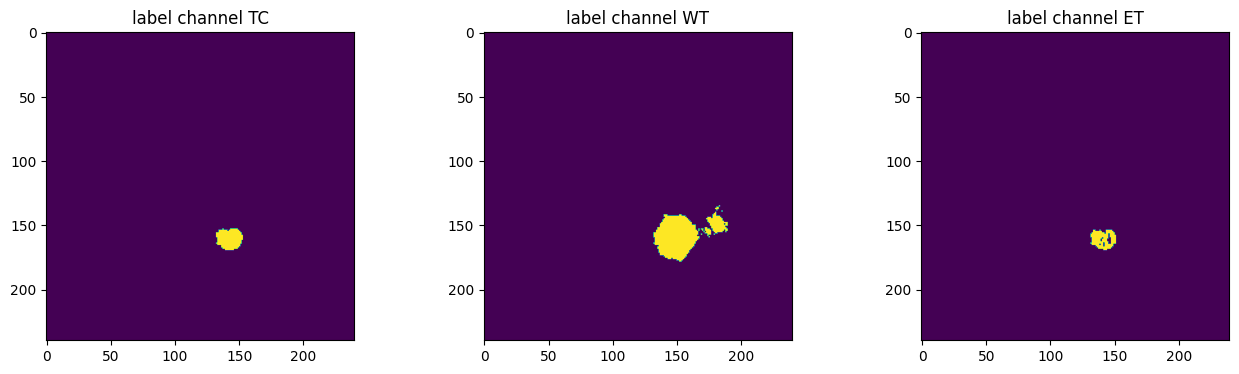

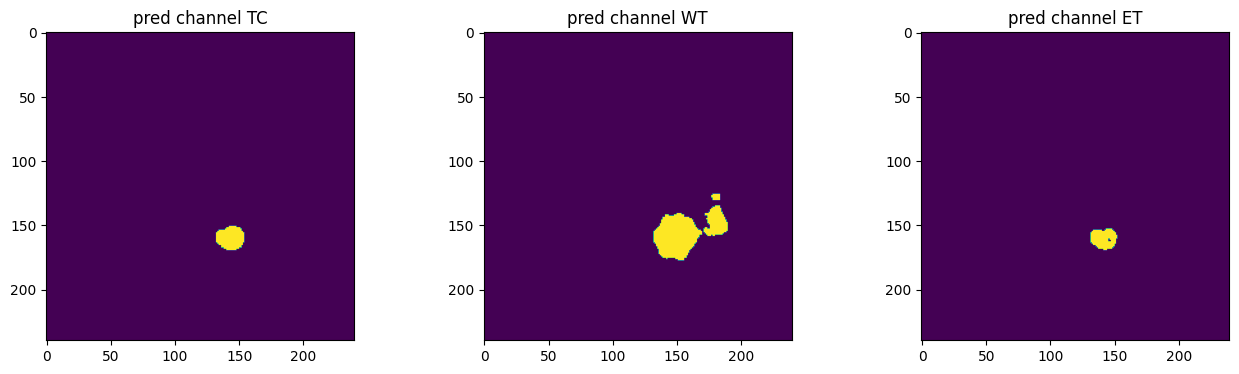

In [28]:
label_map = {
    0: 'TC',
    1: 'WT',
    2: 'ET'
}

plt.figure(figsize=(16, 4))
for i in range(pre_label.shape[-1]):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {label_map[i]}")
    plt.imshow(pre_label[80, :, :, i])
plt.show()

plt.figure(figsize=(16, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"pred channel {label_map[i]}")
    plt.imshow(segment[80, :, :, i])
plt.show()

In [29]:
prediction = np.zeros(
    (segment.shape[0], segment.shape[1], segment.shape[2]),
    dtype='float32'
)
prediction[segment[..., 1] == 1] = 2
prediction[segment[..., 0] == 1] = 1
prediction[segment[..., 2] == 1] = 4

print('label ', orig_label.shape, np.unique(orig_label))
print('predicted ', prediction.shape, np.unique(prediction))

label  (155, 240, 240) [0. 1. 2. 4.]
predicted  (155, 240, 240) [0. 1. 2. 4.]


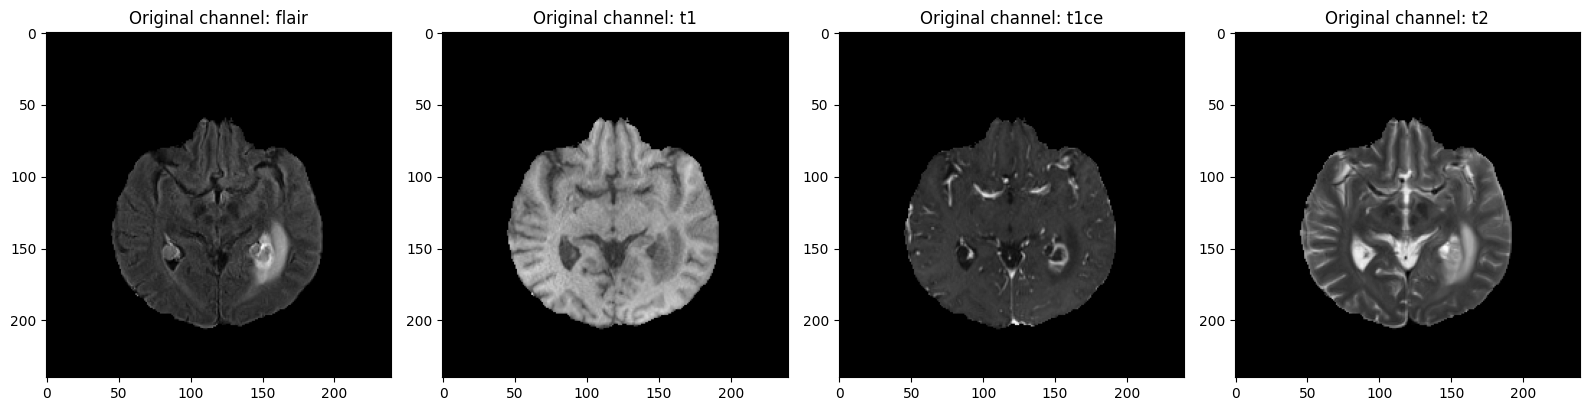

In [30]:
slice_map = {
    0:'flair',
    1:'t1',
    2:'t1ce',
    3:'t2'
}

plt.figure(figsize=(16, 4))
for i in range(orig_image.shape[-1]):
    plt.subplot(1, 4, i + 1)
    plt.title(f"Original channel: {slice_map[i]}")
    plt.imshow(orig_image[60, :, :, i], cmap='gray')

plt.tight_layout()
plt.show()

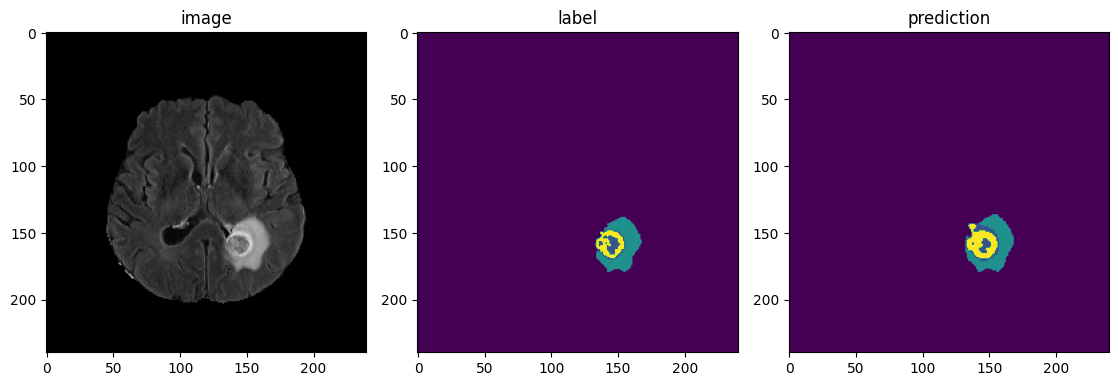

In [31]:
slice_num = 75
num_channels = orig_image.shape[-1]
plt.figure("image", (15, 15))

plt.subplot(3, num_channels, num_channels + 1)
plt.title("image")
plt.imshow(orig_image[slice_num, :, :, 0], cmap='gray')

# plotting labels and prediction
plt.subplot(3, num_channels, num_channels + 2)
plt.title("label")
plt.imshow(orig_label[slice_num, :, :])

plt.subplot(3, num_channels, num_channels + 3)
plt.title("prediction")
plt.imshow(prediction[slice_num, :, :])

plt.tight_layout()
plt.show()

## Additional Resources

- [Covid-19 3D Image Segmentation](https://www.kaggle.com/code/ipythonx/medicai-covid-19-3d-image-segmentation)
- [3D Multi-organ Segmentation - BTCV Challenge](https://www.kaggle.com/code/ipythonx/medicai-3d-btcv-segmentation-in-keras)
- [Spleen 3D segmentation](https://www.kaggle.com/code/ipythonx/medicai-spleen-3d-segmentation-in-keras)